# Theoretical Foundations of Buffer Stock Saving

This notebook uses the [Econ-ARK/HARK](https://github.com/econ-ark/hark) toolkit to reproduce all of the figures in the paper [Theoretical Foundations of Buffer Stock Saving](http://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory).

For instructions on how to install the [Econ-ARK/HARK](https://github.com/econ-ark/hark) toolkit, please refer to II. QUICK START GUIDE in [Heterogeneous Agents Resources and toolKit (HARK)](https://github.com/econ-ark/HARK/blob/master/README.md). Briefly, the recommended installation method is running `pip install econ-ark` in your terminal command line (MacOSX or Linux) or at the Windows command prompt (after installing python and pip for Windows).

If you are not familiar with the HARK toolkit, you may wish to browse the "Gentle Introduction" materials at [https://econ-ark.org/notebooks](https://econ-ark.org/notebooks) before continuing.  If you are not familiar with Jupyter notebooks, Google "jupyter notebooks" to find a tutorial.

The main HARK model module used here is $\texttt{ConsIndShockModel.py}$, in which agents have CRRA utility over consumption and face idiosyncratic shocks to permanent and transitory income.  For an introduction to this module, see [ConsIndShockModel.ipynb](econ-ark.org/notebooks)

In [1]:
# This cell does some setup and imports generic tools used to produce the figures

# Import related generic python packages
import numpy as np
from time import clock
mystr = lambda number : "{:.4f}".format(number)

# This is a jupytext paired notebook that autogenerates BufferStockTheory.py
# which can be executed from a terminal command line via "ipython BufferStockTheory.py"
# But a terminal does not permit inline figures, so we need to test jupyter vs terminal
# Google "how can I check if code is executed in the ipython notebook"
def in_ipynb():
    try:
        if str(type(get_ipython())) == "<class 'ipykernel.zmqshell.ZMQInteractiveShell'>":
            return True
        else:
            return False
    except NameError:
        return False

# Determine whether to make the figures inline (for spyder or jupyter)
# vs whatever is the automatic setting that will apply if run from the terminal
if in_ipynb():
    # %matplotlib inline generates a syntax error when run from the shell
    # so do this instead
    get_ipython().run_line_magic('matplotlib', 'inline') 
else:
    get_ipython().run_line_magic('matplotlib', 'auto') 

# Import the plot-figure library matplotlib

import matplotlib.pyplot as plt

# In order to use LaTeX to manage all text layout in our figures, we import rc settings from matplotlib.
from matplotlib import rc
rc('text', usetex= True)
plt.rc('text', usetex= True)
plt.rc('font', family='serif')


# The warnings package allows us to ignore some harmless but alarming warning messages
import warnings
warnings.filterwarnings("ignore")

# The tools for navigating the filesystem
import sys
import os

sys.path.insert(0, os.path.abspath('../lib'))

# Find pathname to this file:
my_file_path = os.path.dirname(os.path.abspath("BufferStockTheory.ipynb"))

# Define (and create, if necessary) the figures directory "Figures"
Figures_HARK_dir = os.path.join(my_file_path,"Figures/")

if not os.path.exists(Figures_HARK_dir):
    os.makedirs(Figures_HARK_dir)


# Now we can start making the figures.  We start by importing the relevant subclass of $\texttt{AgentType}$ into our workspace.

In [2]:
from HARK.ConsumptionSaving.ConsIndShockModel import IndShockConsumerType

### Convergence of the Consumption Rules

The first figure is in the section **The Baseline Numerical Solution** which depicts the successive consumption rules that apply in the last period of life $(c_{T}(m))$, the second-to-last period, and various earlier periods under the baseline parameter values listed in Table 1 of the paper.

First of all, we define the calibrated parameters in table shown below (same as Table 1 in the paper) using a dictionary, which will also be used as the initial inputs for making an baseline instance of the class $\texttt{IndShockConsumerType}$.

| Param | Description | Code | Value |
| :---: | ---         | ---  | :---: |
| $\Gamma$ | Permanent Income Growth Factor | $\texttt{PermGroFac}$ | 1.03 |
| $\mathrm{\mathsf{R}}$ | Interest Factor | $\texttt{Rfree}$ | 1.04 |
| $\beta$ | Time Preference Factor | $\texttt{DiscFac}$ | 0.96 |
| $\rho$ | Coeﬃcient of Relative Risk Aversion| $\texttt{CRRA}$ | 2 |
| $\wp$ | Probability of Zero Income | $\texttt{UnempPrb}$ | 0.005 |
| $\sigma_\psi$ | Std Dev of Log Permanent Shock| $\texttt{PermShkStd}$ | 0.1 |
| $\sigma_\theta$ | Std Dev of Log Transitory Shock| $\texttt{TranShkStd}$ | 0.1 |

In [3]:
# This cell defines a parameter dictionary for making an instance of IndShockConsumerType, which will be solved as the
# baseline solution in the paper.

baseline_bufferstock_dictionary = {
                    'CRRA': 2,              # Coefficient of relative risk aversion
                    'Rfree': 1.04,          # Interest factor on assets
                    'DiscFac': 0.96,        # Time Preference Factor
                    'LivPrb': [1.0],        # Survival probability (not used in this paper, we set it to 1.0)
                    'PermGroFac': [1.03],   # Permanent income growth factor
                    'AgentCount': 10000,    # Number of agents of this type (unrelated, only matters for simulation)
                    'aXtraMin': 0.001,      # Minimum end-of-period "assets above minimum" value
                    'aXtraMax': 20,         # Maximum end-of-period "assets above minimum" value
                    'aXtraNestFac':20,      # Exponential nesting factor when constructing "assets above minimum" grid
                    'aXtraCount': 48,       # Number of points in the grid of "assets above minimum"
                    'aXtraExtra': [None],   # Some other value of "assets above minimum" to add to the grid, not used
                    'PermShkStd': [0.1],    # Standard deviation of log permanent income shocks
                    'PermShkCount': 3,      # Number of points in discrete approximation to permanent income shocks
                    'TranShkStd': [0.1],    # Standard deviation of log transitory income shocks
                    'TranShkCount': 3,      # Number of points in discrete approximation to transitory income shocks
                    'UnempPrb': 0.005,      # Probability of unemployment (e.g. Probability of Zero Income in the paper)
                    'UnempPrbRet': 0,       # Probability of "unemployment" while retired, not used in the paper
                    'IncUnemp': 0,          # Unemployment benefits replacement rate, not used in the paper
                    'IncUnempRet': 0,       # "Unemployment" benefits when retired, not used in the paper
                    'BoroCnstArt': 0.0,     # Artificial borrowing constraint; imposed minimum level of end-of period assets, not used in the paper
                    'tax_rate':0.0,         # Flat income tax rate, not used in the paper
                    'vFuncBool':False,      # Whether to calculate the value function during solution
                    'CubicBool':True,       # Use cubic spline interpolation when True, linear interpolation when False
                    'T_retire':0,           # Period of retirement (0 --> no retirement)
                    'aNrmInitMean' : 0,     # Mean of log initial assets (only matters for simulation), not used here
                    'aNrmInitStd' : 1,      # Standard deviation of log initial assets (only for simulation),not used here
                    'pLvlInitMean' : 0,     # Mean of log initial permanent income (only matters for simulation), not used here
                    'pLvlInitStd' : 0,      # Standard deviation of log initial permanent income (only matters for simulation), not used here
                    'PermGroFacAgg' : 1,    # Aggregate permanent income growth factor (only matters for simulation), not used here
                    'T_age' : None,         # Age after which simulated agents are automatically killed
                    'T_cycle' :1            # Number of periods in the cycle for this agent type
                    }

In [4]:
# Create the baseline instance by passing the dictionary to the class.
BaselineExample = IndShockConsumerType(**baseline_bufferstock_dictionary)
BaselineExample.cycles = 100 # Make this type have an finite horizon (Set T = 100)

start_time = clock()
BaselineExample.solve()
end_time = clock()
print('Solving a baseline buffer stock saving model (100 periods) took ' + mystr(end_time-start_time) + ' seconds.')
BaselineExample.unpackcFunc()
BaselineExample.timeFwd()

Solving a baseline buffer stock saving model (100 periods) took 0.2505 seconds.


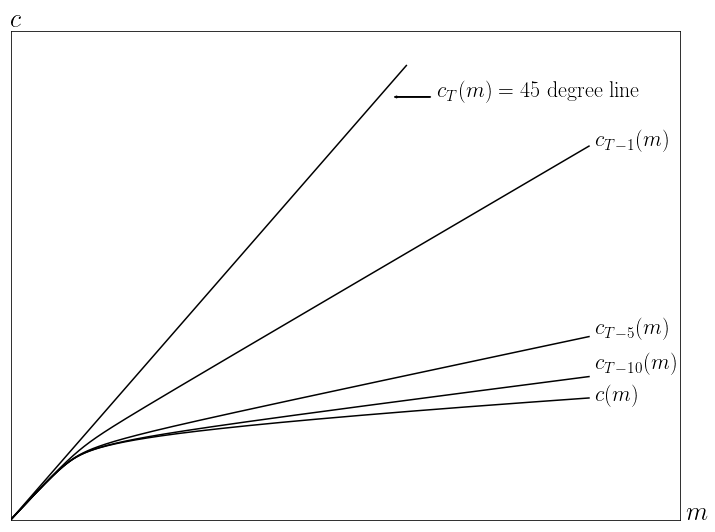

In [5]:
# Now we start plotting the different periods' consumption rules.

m1 = np.linspace(0,9.5,1000) # Set the plot range of m
m2 = np.linspace(0,6.5,500)
c_m = BaselineExample.cFunc[0](m1)   # c_m can be used to define the limiting inﬁnite-horizon consumption rule here
c_t1 = BaselineExample.cFunc[-2](m1) # c_t1 defines the second-to-last period consumption rule
c_t5 = BaselineExample.cFunc[-6](m1) # c_t5 defines the T-5 period consumption rule
c_t10 = BaselineExample.cFunc[-11](m1)  # c_t10 defines the T-10 period consumption rule
c_t0 = m2                            # c_t0 defines the last period consumption rule
plt.figure(figsize = (12,9))
plt.plot(m1,c_m,color="black")
plt.plot(m1,c_t1,color="black")
plt.plot(m1,c_t5,color="black")
plt.plot(m1,c_t10,color="black")
plt.plot(m2,c_t0,color="black")
plt.xlim(0,11)
plt.ylim(0,7)
plt.text(7,6,r'$c_{T}(m) = 45$ degree line',fontsize = 22,fontweight='bold')
plt.text(9.6,5.3,r'$c_{T-1}(m)$',fontsize = 22,fontweight='bold')
plt.text(9.6,2.6,r'$c_{T-5}(m)$',fontsize = 22,fontweight='bold')
plt.text(9.6,2.1,r'$c_{T-10}(m)$',fontsize = 22,fontweight='bold')
plt.text(9.6,1.7,r'$c(m)$',fontsize = 22,fontweight='bold')
plt.arrow(6.9,6.05,-0.6,0,head_width= 0.03,width=0.001,facecolor='black',length_includes_head='True')
plt.tick_params(labelbottom=False, labelleft=False,left='off',right='off',bottom='off',top='off')
plt.text(0,7.05,"$c$",fontsize = 26)
plt.text(11.1,0,"$m$",fontsize = 26)
# Save the figures in several formats
plt.savefig(os.path.join(Figures_HARK_dir, 'cFuncsConverge.png'))
plt.savefig(os.path.join(Figures_HARK_dir, 'cFuncsConverge.jpg'))
plt.savefig(os.path.join(Figures_HARK_dir, 'cFuncsConverge.pdf'))
plt.savefig(os.path.join(Figures_HARK_dir, 'cFuncsConverge.svg'))


# The figure illustrates convergence of the consumption rules as the horizon recedes

# ### Example Solution when FVAC Holds but GIC Does Not

# This figure is shown in the section **The GIC**. It depicts a solution when **FVAC** (Finite Value of Autarky Condition) holds (so that the model has a solution) but the **GIC** (Growth Impatience Condition) fails.

# The parameter values in this specific example are listed in the following table:
#
# | Param | Description | Code | Value |
# | :---: | ---         | ---  | :---: |
# | $\Gamma$ | Permanent Income Growth Factor | $\texttt{PermGroFac}$ | 1.00 |
# | $\mathrm{\mathsf{R}}$ | Interest Factor | $\texttt{Rfree}$ | 1.08 |
# | $\beta$ | Time Preference Factor | $\texttt{DiscFac}$ | 0.96 |
# | $\rho$ | Coeﬃcient of Relative Risk Aversion| $\texttt{CRRA}$ | 2 |
# | $\wp$ | Probability of Zero Income | $\texttt{UnempPrb}$ | 0.005 |
# | $\sigma_\psi$ | Std Dev of Log Permanent Shock| $\texttt{PermShkStd}$ | 0.1 |
# | $\sigma_\theta$ | Std Dev of Log Transitory Shock| $\texttt{TranShkStd}$ | 0.1 |

In [6]:
# CDC to PKM: Please redo this by making a copy of the baseline parameters, then REPLACING only the ones that you change 
# Define the corresponding dictionary to make an instance of IndShockConsumerType
# for the "GIC fails" example.
GIC_fail_dictionary = { 'CRRA': 2,
                              'Rfree': 1.08,
                              'DiscFac': 0.96,
                              'LivPrb': [1.0],
                              'PermGroFac': [1.00],
                              'AgentCount': 10000,
                              'aXtraMin': 0.001,
                              'aXtraMax': 20,
                              'aXtraNestFac':20,
                              'aXtraCount': 48,
                              'aXtraExtra': [None],
                              'PermShkStd': [0.1],
                              'PermShkCount': 3,
                              'TranShkStd': [0.1],
                              'TranShkCount': 3,
                              'UnempPrb': 0.005,
                              'UnempPrbRet': 0,
                              'IncUnemp': 0,
                              'IncUnempRet': 0,
                              'BoroCnstArt': 0.0,
                              'tax_rate':0.0,
                              'vFuncBool':False,
                              'CubicBool':True,
                              'T_retire':0,
                              'aNrmInitMean' : 0,
                              'aNrmInitStd' : 1,
                              'pLvlInitMean' : 0,
                              'pLvlInitStd' : 0,
                              'PermGroFacAgg' : 1,
                              'T_age' : None,
                              'T_cycle' :1
                             }

## The Absolute Patience Factor

The paper defines an object assigned to the Old English character <span style="font-size:larger;">"&#222;"</span>, which is called the Absolute Patience Factor.  For technical reasons, this character cannot currently be rendered conveniently in Jupyter notebooks, so we will substitute $\Phi$ here.  

$\Phi$ is just the ratio of $C_{t+1}/C_{t}$ for a perfect foresight consumer.

If $\Phi = 1$, such a consumer will spend exactly the amount that can be sustained perpetually, given their current and future resources.  If $\Phi < 1$ (the consumer is 'absolutely impatient'; or, 'the absolute impatience condition holds'), the consumer is consuming more than the sustainable amount, so consumption will fall, and if the consumer is 'absolutely patient' with $\Phi > 1$ consumption will grow over time.



## The Growth Patience Factor

For a perfect foresight consumer, whether the ratio of consumption to the permanent component of income $P$ is rising, constant, or falling depends on the relative growth rates of consumption and permanent income, which is measured by 

\begin{eqnarray}
\Phi_{\Gamma} = \Phi/\Gamma
\end{eqnarray}

If the consumer is 'growth impatient,' the $\textit{ratio}$ of consumption to permanent income will be falling ($\Phi_{\Gamma}<1$), while $C/P$ will be rising if ($\Phi_{\Gamma}>1$).  

If the ratio of consumption to income is rising forever, it might seem likely that the model does not have a solution; that is incorrect, as the example below demonstrates.

In [7]:
# Solve for the GICFailExample consumption function
GICFailExample = IndShockConsumerType(**GIC_fail_dictionary)
GICFailExample.cycles = 0 # Make this type have an infinite horizon

In [8]:
# We've set up the problem so GIC is not satisfied. This can be checked by using the method checkConditions
GICFailExample.checkConditions()

The return impatience factor value for the supplied parameter values satisfies the return impatience condition.
The given type violates the absolute impatience condition with the supplied parameter values; the AIF is 1.01823 
The finite human wealth factor value for the supplied parameter values satisfies the finite human wealth condition.
The given parameter values violate the growth impatience condition for this consumer type; the GIF is: 1.0102
The weak return impatience factor value for the supplied parameter values satisfies the weak return impatience condition.
The finite value of autarky factor value for the supplied parameter values satisfies the finite value of autarky condition.


In [9]:
# or with more information
GICFailExample.checkConditions(verbose=True)

The return impatience factor value for the supplied parameter values satisfies the return impatience condition.
The given type violates the absolute impatience condition with the supplied parameter values; the AIF is 1.01823 
    Therefore, the absolute amount of consumption is expected to grow over time
The finite human wealth factor value for the supplied parameter values satisfies the finite human wealth condition.
[!] For more information on the conditions, see Table 3 in "Theoretical Foundations of Buffer Stock Saving" at http://econ.jhu.edu/people/ccarroll/papers/BufferStockTheory/
The given parameter values violate the growth impatience condition for this consumer type; the GIF is: 1.0102
    Therefore, a target level of wealth does not exist.
The weak return impatience factor value for the supplied parameter values satisfies the weak return impatience condition.
The finite value of autarky factor value for the supplied parameter values satisfies the finite value of autarky cond

In [10]:
# Solve the model under conditions that fail the GIC
start_time = clock()
GICFailExample.solve()
end_time = clock()
print('Solving the GICFailExample consumer took ' + mystr(end_time-start_time) + ' seconds.')
GICFailExample.unpackcFunc()
GICFailExample.timeFwd()


# Next we define the function $\mathrm{\mathbb{E}}_{t}[\Delta m_{t+1}]$ that shows the ‘sustainable’ level of spending at which $m$ is expected to remain unchanged.

Solving the GICFailExample consumer took 1.6495 seconds.


In [11]:
# Calculate "Sustainable" consumption that leaves expected m unchanged.
InvEpShInvAct = np.dot(GICFailExample.PermShkDstn[0][0], GICFailExample.PermShkDstn[0][1]**(-1))
InvInvEpShInvAct = (InvEpShInvAct) ** (-1)
PermGroFacAct = GICFailExample.PermGroFac[0] * InvInvEpShInvAct
ER = GICFailExample.Rfree / PermGroFacAct
Er = ER - 1
mSSfunc = lambda m : 1 + (m-1)*(Er/ER)

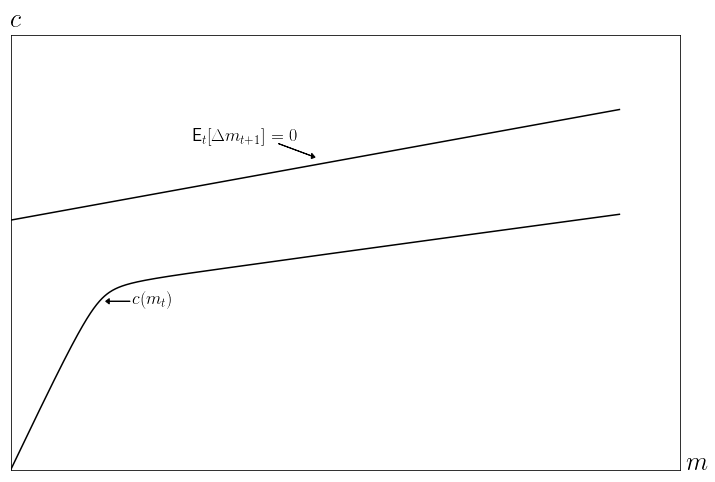

In [12]:
# Plot GICFailExample consumption function against the sustainable level of consumption
m = np.linspace(0,5,1000)
c_m = GICFailExample.cFunc[0](m)
E_m = mSSfunc(m)
plt.figure(figsize = (12,8))
plt.plot(m,c_m,color="black")
plt.plot(m,E_m,color="black")
plt.xlim(0,5.5)
plt.ylim(0,1.6)
plt.text(0,1.63,"$c$",fontsize = 26)
plt.text(5.55,0,"$m$",fontsize = 26)
plt.tick_params(labelbottom=False, labelleft=False,left='off',right='off',bottom='off',top='off')
plt.text(1,0.6,"$c(m_{t})$",fontsize = 18)
plt.text(1.5,1.2,"$\mathrm{\mathsf{E}}_{t}[\Delta m_{t+1}] = 0$",fontsize = 18)
plt.arrow(0.98,0.62,-0.2,0,head_width= 0.02,width=0.001,facecolor='black',length_includes_head='True')
plt.arrow(2.2,1.2,0.3,-0.05,head_width= 0.02,width=0.001,facecolor='black',length_includes_head='True')
plt.savefig(os.path.join(Figures_HARK_dir, 'FVACnotGIC.png'))
plt.savefig(os.path.join(Figures_HARK_dir, 'FVACnotGIC.jpg'))
plt.savefig(os.path.join(Figures_HARK_dir, 'FVACnotGIC.pdf'))
plt.savefig(os.path.join(Figures_HARK_dir, 'FVACnotGIC.svg'))

# This figure reproduces the figure shown in the paper.  The gap between the two functions actually increases with $m$ in the limit.

In [13]:
# As a foundation for the remaining figures, we define another instance of the class $\texttt{IndShockConsumerType}$, which has the same parameter values as the instance $\texttt{BaselineExample}$ defined previously but is solved to convergence (our definition of an infinite horizon agent type)
BaselineExample_inf = IndShockConsumerType(**baseline_bufferstock_dictionary)
BaselineExample_inf.cycles = 0 # Make this type have an infinite horizon; see HARK documentation

start_time = clock()
BaselineExample_inf.solve()
end_time = clock()
#print('Solving a consumer with idiosyncratic shocks took ' + mystr(end_time-start_time) + ' seconds.')
BaselineExample_inf.unpackcFunc()
BaselineExample_inf.timeFwd()

### Target $m$, Expected Consumption Growth, and Permanent Income Growth

This figure is shown in  **Analysis of the Converged Consumption Function**, which shows the expected consumption growth factor $\mathrm{\mathbb{E}}_{t}[c_{t+1}/c_{t}]$ for a consumer behaving according to the converged consumption rule.

The first step is about how to calculate the t+1 period expected consumption. We define an auxiliary function to calculate the expectation of t+1 period consumption given t end-of-period assets.

In [14]:
# Define function to calculate expected consumption in t+1 period given assets at end of t.
def exp_consumption(a):
    '''
    Taking end-of-period assets as input, return expectation of next period's consumption

    Inputs:
       a: end-of-period assets

    Returns:
       sum(part_expconsump_l): next period's expected consumption
    '''
    GrowFactp1 = BaselineExample_inf.PermGroFac[0]* BaselineExample_inf.PermShkDstn[0][1]
    Rnrmtp1 = BaselineExample_inf.Rfree / GrowFactp1
    btp1 = Rnrmtp1*a
    mtp1 = np.expand_dims(btp1, axis=1) + BaselineExample_inf.TranShkDstn[0][1]
    part_expconsumption = GrowFactp1*BaselineExample_inf.cFunc[0](mtp1).T
    part_expconsumption = np.dot(part_expconsumption, BaselineExample_inf.PermShkDstn[0][0])
    expconsumption = np.dot(part_expconsumption, BaselineExample_inf.TranShkDstn[0][0])
    return expconsumption

In [15]:
# Calculate the expected consumption growth factor
m1 = np.linspace(1,BaselineExample_inf.solution[0].mNrmSS,50) # m1 defines the plot range on the left of target m value (e.g. m <= target m)
c_m1 = BaselineExample_inf.cFunc[0](m1)
a1 = m1-c_m1
exp_consumption_l1 = []
for i in range(len(a1)):
    exp_consumption_tp1 = exp_consumption(a1[i])
    exp_consumption_l1.append(exp_consumption_tp1)

# growth1 defines the values of expected consumption growth factor when m is less than target m
growth1 = np.array(exp_consumption_l1)/c_m1

# m2 defines the plot range on the right of target m value (e.g. m >= target m)
m2 = np.linspace(BaselineExample_inf.solution[0].mNrmSS,1.9,50)

c_m2 = BaselineExample_inf.cFunc[0](m2)
a2 = m2-c_m2
exp_consumption_l2 = []
for i in range(len(a2)):
    exp_consumption_tp1 = exp_consumption(a2[i])
    exp_consumption_l2.append(exp_consumption_tp1)

# growth 2 defines the values of expected consumption growth factor when m is bigger than target m
growth2 = np.array(exp_consumption_l2)/c_m2

In [16]:
# Define a function to construct the arrows on the consumption growth rate function
def arrowplot(axes, x, y, narrs=15, dspace=0.5, direc='neg',
              hl=0.01, hw=3, c='black'):
    '''
    The function is used to plot arrows given the data x and y.

    Input:
        narrs  :  Number of arrows that will be drawn along the curve

        dspace :  Shift the position of the arrows along the curve.
                  Should be between 0. and 1.

        direc  :  can be 'pos' or 'neg' to select direction of the arrows

        hl     :  length of the arrow head

        hw     :  width of the arrow head

        c      :  color of the edge and face of the arrow head
    '''

    # r is the distance spanned between pairs of points
    r = np.sqrt(np.diff(x)**2+np.diff(y)**2)
    r = np.insert(r, 0, 0.0)

    # rtot is a cumulative sum of r, it's used to save time
    rtot = np.cumsum(r)

    # based on narrs set the arrow spacing
    aspace = r.sum() / narrs

    if direc is 'neg':
        dspace = -1.*abs(dspace)
    else:
        dspace = abs(dspace)

    arrowData = [] # will hold tuples of x,y,theta for each arrow
    arrowPos = aspace*(dspace) # current point on walk along data
                                 # could set arrowPos to 0 if you want
                                 # an arrow at the beginning of the curve

    ndrawn = 0
    rcount = 1
    while arrowPos < r.sum() and ndrawn < narrs:
        x1,x2 = x[rcount-1],x[rcount]
        y1,y2 = y[rcount-1],y[rcount]
        da = arrowPos-rtot[rcount]
        theta = np.arctan2((x2-x1),(y2-y1))
        ax = np.sin(theta)*da+x1
        ay = np.cos(theta)*da+y1
        arrowData.append((ax,ay,theta))
        ndrawn += 1
        arrowPos+=aspace
        while arrowPos > rtot[rcount+1]:
            rcount+=1
            if arrowPos > rtot[-1]:
                break

    for ax,ay,theta in arrowData:
        # use aspace as a guide for size and length of things
        # scaling factors were chosen by experimenting a bit

        dx0 = np.sin(theta)*hl/2.0 + ax
        dy0 = np.cos(theta)*hl/2.0 + ay
        dx1 = -1.*np.sin(theta)*hl/2.0 + ax
        dy1 = -1.*np.cos(theta)*hl/2.0 + ay

        if direc is 'neg' :
            ax0 = dx0
            ay0 = dy0
            ax1 = dx1
            ay1 = dy1
        else:
            ax0 = dx1
            ay0 = dy1
            ax1 = dx0
            ay1 = dy0

        axes.annotate('', xy=(ax0, ay0), xycoords='data',
                xytext=(ax1, ay1), textcoords='data',
                arrowprops=dict( headwidth=hw, frac=1., ec=c, fc=c))

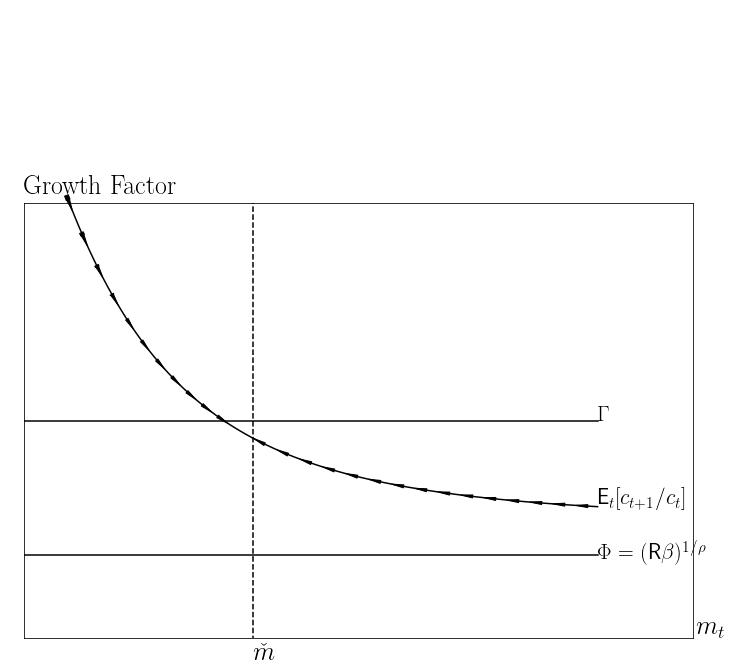

In [17]:
# Plot consumption growth as a function of market resources
# Calculate Absolute Patience Factor Phi = lower bound of consumption growth factor
AbsPatientFac = (BaselineExample_inf.Rfree*BaselineExample_inf.DiscFac)**(1.0/BaselineExample_inf.CRRA)

fig = plt.figure(figsize = (12,8))
ax = fig.add_subplot(111)
# Plot the Absolute Patience Factor line
ax.plot([0,1.9],[AbsPatientFac,AbsPatientFac],color="black")

# Plot the Permanent Income Growth Factor line
ax.plot([0,1.9],[BaselineExample_inf.PermGroFac[0],BaselineExample_inf.PermGroFac[0]],color="black")

# Plot the expected consumption growth factor on the left side of target m
ax.plot(m1,growth1,color="black")

# Plot the expected consumption growth factor on the right side of target m
ax.plot(m2,growth2,color="black")

# Plot the arrows
arrowplot(ax, m1,growth1)
arrowplot(ax, m2,growth2, direc='pos')

# Plot the target m
ax.plot([BaselineExample_inf.solution[0].mNrmSS,BaselineExample_inf.solution[0].mNrmSS],[0,1.4],color="black",linestyle="--")
ax.set_xlim(1,2.05)
ax.set_ylim(0.98,1.08)
ax.text(1,1.082,"Growth Factor",fontsize = 26,fontweight='bold')
ax.text(2.055,0.98,"$m_{t}$",fontsize = 26,fontweight='bold')
ax.text(1.9,1.01,"$\mathrm{\mathsf{E}}_{t}[c_{t+1}/c_{t}]$",fontsize = 22,fontweight='bold')
ax.text(BaselineExample_inf.solution[0].mNrmSS,0.975, r'$\check{m}$', fontsize = 26,fontweight='bold')
ax.tick_params(labelbottom=False, labelleft=False,left='off',right='off',bottom='off',top='off')
ax.text(1.9,0.998,r'$\Phi = (\mathrm{\mathsf{R}}\beta)^{1/\rho}$',fontsize = 22,fontweight='bold')
ax.text(1.9,1.03, r'$\Gamma$',fontsize = 22,fontweight='bold')
fig.savefig(os.path.join(Figures_HARK_dir, 'cGroTargetFig.png'))
fig.savefig(os.path.join(Figures_HARK_dir, 'cGroTargetFig.jpg'))
fig.savefig(os.path.join(Figures_HARK_dir, 'cGroTargetFig.pdf'))
fig.savefig(os.path.join(Figures_HARK_dir, 'cGroTargetFig.svg'))

### The Consumption Function Bounds

The next figure is also shown in **Analysis of the Converged Consumption Function**, which illustrates theoretical bounds for the consumption function.

We define two useful variables: lower bound of $\kappa$ (marginal propensity to consume) and limit of $h$ (Human wealth), along with some functions such as perfect foresight consumption function ($\bar{c}(m)$), $\bar{\bar c}(m)$ and $\underline{c}(m)$.

In [18]:
# Define k_lower, h_inf and perfect foresight consumption function, upper bound of consumption function and lower
# bound of consumption function.
k_lower = 1.0-(BaselineExample_inf.Rfree**(-1.0))*(BaselineExample_inf.Rfree*BaselineExample_inf.DiscFac)**(1.0/BaselineExample_inf.CRRA)
h_inf = (1.0/(1.0-BaselineExample_inf.PermGroFac[0]/BaselineExample_inf.Rfree))
conFunc_PF = lambda m: (h_inf -1)* k_lower + k_lower*m
conFunc_upper = lambda m: (1 - BaselineExample_inf.UnempPrb ** (1.0/BaselineExample_inf.CRRA)*(BaselineExample_inf.Rfree*BaselineExample_inf.DiscFac)**(1.0/BaselineExample_inf.CRRA)/BaselineExample_inf.Rfree)*m
conFunc_lower = lambda m: (1 -(BaselineExample_inf.Rfree*BaselineExample_inf.DiscFac)**(1.0/BaselineExample_inf.CRRA)/BaselineExample_inf.Rfree) * m
intersect_m = ((h_inf-1)* k_lower)/((1 - BaselineExample_inf.UnempPrb
            **(1.0/BaselineExample_inf.CRRA)*(BaselineExample_inf.Rfree*BaselineExample_inf.DiscFac)**(1.0/BaselineExample_inf.CRRA)/BaselineExample_inf.Rfree)-k_lower)

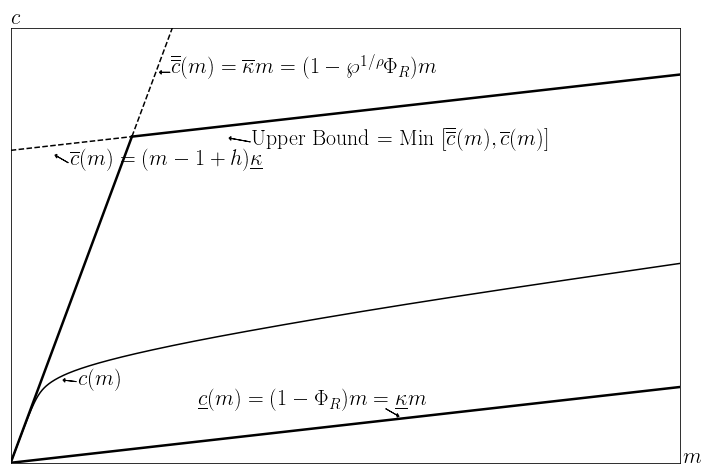

In [19]:
# Plot consumption function and its bounds
x1 = np.linspace(0,25,1000)
x3 = np.linspace(0,intersect_m,300)
x4 = np.linspace(intersect_m,25,700)
cfunc_m = BaselineExample_inf.cFunc[0](x1)
cfunc_PF_1 = conFunc_PF(x3)
cfunc_PF_2 = conFunc_PF(x4)
cfunc_upper_1 = conFunc_upper(x3)
cfunc_upper_2 = conFunc_upper(x4)
cfunc_lower = conFunc_lower(x1)
plt.figure(figsize = (12,8))
plt.plot(x1,cfunc_m, color="black")
plt.plot(x1,cfunc_lower, color="black",linewidth=2.5)
plt.plot(x3,cfunc_upper_1, color="black",linewidth=2.5)
plt.plot(x4,cfunc_PF_2 , color="black",linewidth=2.5)
plt.plot(x4,cfunc_upper_2 , color="black",linestyle="--")
plt.plot(x3,cfunc_PF_1 , color="black",linestyle="--")
plt.tick_params(labelbottom=False, labelleft=False,left='off',right='off',bottom='off',top='off')
plt.xlim(0,25)
plt.ylim(0,1.12*conFunc_PF(25))
plt.text(0,1.12*conFunc_PF(25)+0.05,"$c$",fontsize = 22)
plt.text(25+0.1,0,"$m$",fontsize = 22)
plt.text(2.5,1,r'$c(m)$',fontsize = 22,fontweight='bold')
plt.text(6,5,r'$\overline{\overline c}(m)= \overline{\kappa}m = (1-\wp^{1/\rho}\Phi_{R})m$',fontsize = 22,fontweight='bold')
plt.text(2.2,3.8, r'$\overline{c}(m) = (m-1+h)\underline{\kappa}$',fontsize = 22,fontweight='bold')
plt.text(9,4.1,r'Upper Bound $ = $ Min $[\overline{\overline c}(m),\overline{c}(m)]$',fontsize = 22,fontweight='bold')
plt.text(7,0.7,r'$\underline{c}(m)= (1-\Phi_{R})m = \underline{\kappa}m$',fontsize = 22,fontweight='bold')
plt.arrow(2.45,1.05,-0.5,0.02,head_width= 0.05,width=0.001,facecolor='black',length_includes_head='True')
plt.arrow(2.15,3.88,-0.5,0.1,head_width= 0.05,width=0.001,facecolor='black',length_includes_head='True')
plt.arrow(8.95,4.15,-0.8,0.05,head_width= 0.05,width=0.001,facecolor='black',length_includes_head='True')
plt.arrow(5.95,5.05,-0.4,0,head_width= 0.05,width=0.001,facecolor='black',length_includes_head='True')
plt.arrow(14,0.70,0.5,-0.1,head_width= 0.05,width=0.001,facecolor='black',length_includes_head='True')
plt.savefig(os.path.join(Figures_HARK_dir, 'cFuncBounds.png'))
plt.savefig(os.path.join(Figures_HARK_dir, 'cFuncBounds.jpg'))
plt.savefig(os.path.join(Figures_HARK_dir, 'cFuncBounds.pdf'))
plt.savefig(os.path.join(Figures_HARK_dir, 'cFuncBounds.svg'))

### The Consumption Function and Target $m$

This figure shows the $\mathrm{\mathbb{E}}_{t}[\Delta m_{t+1}]$ and consumption function $c(m_{t})$, along with the intrsection of these two functions, which defines the target value of $m$

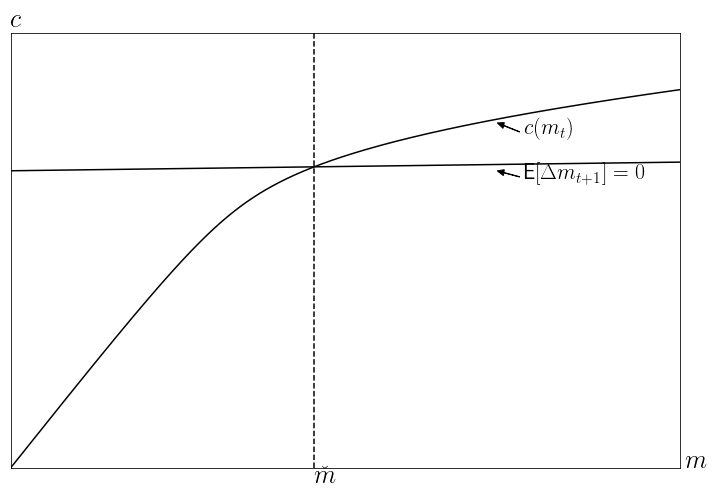

In [20]:
# This just plots objects that have already been constructed
m1 = np.linspace(0,4,1000)
cfunc_m = BaselineExample_inf.cFunc[0](m1)
mSSfunc = lambda m:(BaselineExample_inf.PermGroFac[0]/BaselineExample_inf.Rfree)+(1.0-BaselineExample_inf.PermGroFac[0]/BaselineExample_inf.Rfree)*m
mss = mSSfunc(m1)
plt.figure(figsize = (12,8))
plt.plot(m1,cfunc_m, color="black")
plt.plot(m1,mss, color="black")
plt.xlim(0,3)
plt.ylim(0,1.45)
plt.plot([BaselineExample_inf.solution[0].mNrmSS, BaselineExample_inf.solution[0].mNrmSS],[0,2.5],color="black",linestyle="--")
plt.tick_params(labelbottom=False, labelleft=False,left='off',right='off',bottom='off',top='off')
plt.text(0,1.47,r"$c$",fontsize = 26)
plt.text(3.02,0,r"$m$",fontsize = 26)
plt.text(2.3,0.95,r'$\mathrm{\mathsf{E}}[\Delta m_{t+1}] = 0$',fontsize = 22,fontweight='bold')
plt.text(2.3,1.1,r"$c(m_{t})$",fontsize = 22,fontweight='bold')
plt.text(BaselineExample_inf.solution[0].mNrmSS,-0.05, r"$\check{m}$",fontsize = 26)
plt.arrow(2.28,1.12,-0.1,0.03,head_width= 0.02,width=0.001,facecolor='black',length_includes_head='True')
plt.arrow(2.28,0.97,-0.1,0.02,head_width= 0.02,width=0.001,facecolor='black',length_includes_head='True')
plt.savefig(os.path.join(Figures_HARK_dir, 'cRatTargetFig.png'))
plt.savefig(os.path.join(Figures_HARK_dir, 'cRatTargetFig.jpg'))
plt.savefig(os.path.join(Figures_HARK_dir, 'cRatTargetFig.pdf'))
plt.savefig(os.path.join(Figures_HARK_dir, 'cRatTargetFig.svg'))

### Upper and Lower Limits of the Marginal Propensity to Consume

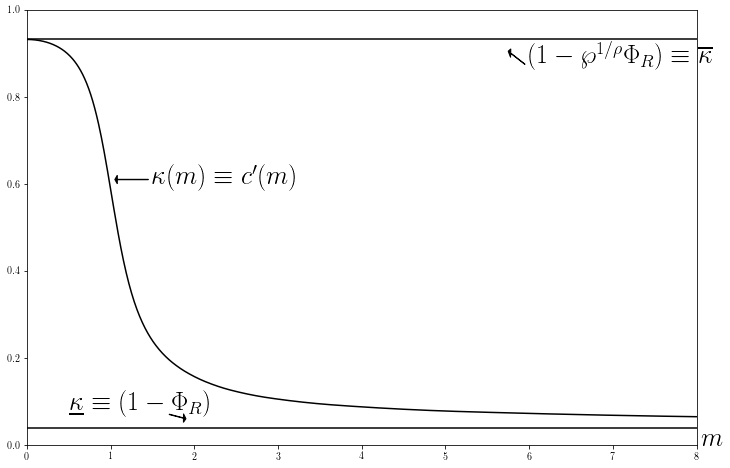

In [21]:
# The last figure shows the upper and lower limits of the MPC
plt.figure(figsize = (12,8))
# Set the plot range of m
m = np.linspace(0.001,8,1000)

# Use the HARK method derivative to get the derivative of cFunc, and the values are just the MPC
MPC = BaselineExample_inf.cFunc[0].derivative(m)

# Define the upper bound of MPC
MPCUpper = (1 - BaselineExample_inf.UnempPrb ** (1.0/BaselineExample_inf.CRRA)*(BaselineExample_inf.Rfree*BaselineExample_inf.DiscFac)**(1.0/BaselineExample_inf.CRRA)/BaselineExample_inf.Rfree)

# Define the lower bound of MPC
MPCLower = k_lower

plt.plot(m,MPC,color = 'black')
plt.plot([0,8],[MPCUpper,MPCUpper],color = 'black')
plt.plot([0,8],[MPCLower,MPCLower],color = 'black')
plt.xlim(0,8)
plt.ylim(0,1)
plt.text(1.5,0.6,r'$\kappa(m) \equiv c^{\prime}(m)$',fontsize = 26,fontweight='bold')
plt.text(6,0.87,r'$(1-\wp^{1/\rho}\Phi_{R})\equiv \overline{\kappa}$',fontsize = 26,fontweight='bold')
plt.text(0.5,0.07,r'$\underline{\kappa}\equiv(1-\Phi_{R})$',fontsize = 26,fontweight='bold')
plt.text(8.05,0,"$m$",fontsize = 26)
plt.arrow(1.45,0.61,-0.4,0,head_width= 0.02,width=0.001,facecolor='black',length_includes_head='True')
plt.arrow(1.7,0.07,0.2,-0.01,head_width= 0.02,width=0.001,facecolor='black',length_includes_head='True')
plt.arrow(5.95,0.875,-0.2,0.03,head_width= 0.02,width=0.001,facecolor='black',length_includes_head='True')
plt.savefig(os.path.join(Figures_HARK_dir, 'MPCLimits.png'))
plt.savefig(os.path.join(Figures_HARK_dir, 'MPCLimits.jpg'))
plt.savefig(os.path.join(Figures_HARK_dir, 'MPCLimits.pdf'))
plt.savefig(os.path.join(Figures_HARK_dir, 'MPCLimits.svg'))